AE_27_200_200_200_18_200_200_200_27 best_AE_bn_LeakyReLU_bs4096_lr1e-02_wd1e-02


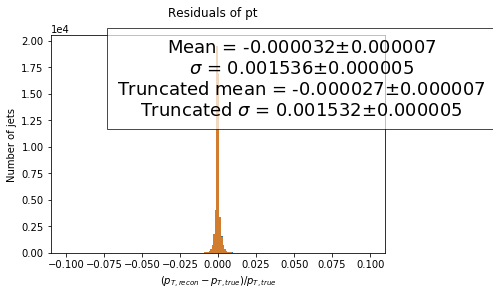

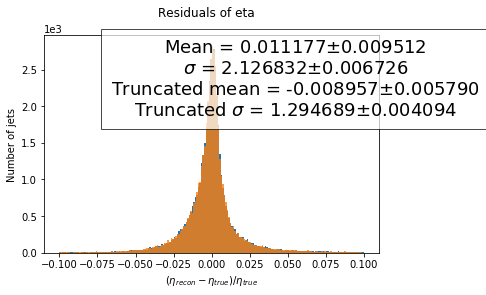

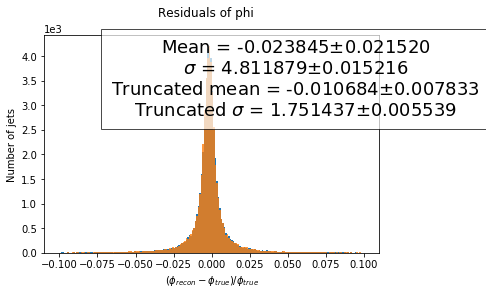

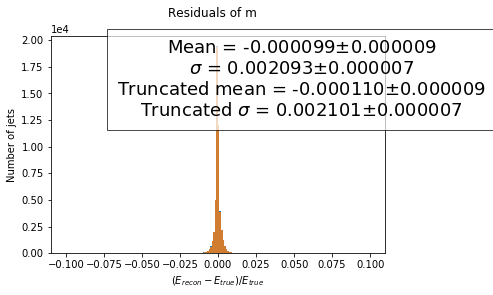

In [9]:
"""
This script analyses the difference in residuals between two datasets: 
an uncompressed one and one lossy-compressed by float truncation (with the mantissa reduced)

How the original xAOD is compressed will not be expanded upon here, see Athena.
"""

import sys
import os
import numpy as np
BIN = '../'
sys.path.append(BIN)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import my_matplotlib_style as ms
from scipy import stats
import utils

import torch
import torch.nn as nn
import torch.utils.data

from torch.utils.data import TensorDataset
from fastai.callbacks.tracker import SaveModelCallback

from fastai import basic_train, basic_data
from fastai.callbacks import ActivationStats
from fastai import train as tr

from nn_utils import get_data, RMSELoss
from utils import plot_activations

from nn_utils import AE_basic, AE_bn_LeakyReLU

# Load data
train = pd.read_pickle(BIN + 'processed_data/aod/all_jets_train_27D_5_percent.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/all_jets_test_27D_5_percent.pkl')

# Load compressed data
train_comp = pd.read_pickle(BIN + 'processed_data/aod/all_jets_train_27D_5_percent.pkl')
test_comp = pd.read_pickle(BIN + 'processed_data/aod/all_jets_test_27D_5_percent.pkl')

# Remove extreme/bad jets
train = utils.filter_jets(train)
test = utils.filter_jets(test)
train_comp = utils.filter_jets(train_comp)
test_comp = utils.filter_jets(test_comp)

# Normalize
train_mean = train.mean()
train_std = train.std()

train_comp_mean = train_comp.mean()
train_comp_std = train_comp.std()

train, test = utils.custom_normalization(train, test)
train_comp, test_comp = utils.custom_normalization(train_comp, test_comp)

train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_comp_x = train_comp
test_comp_x = test_comp
train_comp_y = train_comp_x 
test_comp_y = test_comp_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))
train_dl, valid_dl = get_data(train_ds, valid_ds, bs=1024)
db = basic_data.DataBunch(train_dl, valid_dl)

train_comp_ds = TensorDataset(torch.tensor(train_comp_x.values), torch.tensor(train_comp_y.values))
valid_comp_ds = TensorDataset(torch.tensor(test_comp_x.values), torch.tensor(test_comp_y.values))
train_comp_dl, valid_comp_dl = get_data(train_comp_ds, valid_comp_ds, bs=1024)
comp_db = basic_data.DataBunch(train_comp_dl, valid_comp_dl)

module_name = 'AE_bn_LeakyReLU'
module = AE_bn_LeakyReLU
grid_search_folder = "AE_bn_LeakyReLU_AOD_grid_search_custom_normalization_1500epochs/"

loss_func = nn.MSELoss()

#The folder to analyse
model_folder_name = "AE_27_200_200_200_18_200_200_200_27"

plt.close('all')

#Just alter this if you want to iterate through every model
for model_folder in [x for x in os.scandir(grid_search_folder) if x.name == model_folder_name]:
    if model_folder.is_dir():
        for train_folder in os.scandir(grid_search_folder + model_folder.name):
            if train_folder.is_dir() and train_folder.name == 'models':
                plt.close('all')

                #Find the best model
                for f in os.scandir(grid_search_folder + model_folder.name + '/' + train_folder.name + '/'):
                    if f.name[:4] == "best":
                        saved_model_fname = f.name[:-4]
                        print(model_folder.name + " " + f.name[:-4])

                #Load model
                nodes = model_folder.name.split('AE_')[1].split('_')
                nodes = [int(x) for x in nodes]
                model = module(nodes)
                learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, true_wd=True)
                learn.model_dir = grid_search_folder + model_folder.name + '/' + 'models/'
                learn.load(saved_model_fname)
                #model.load_state_dict(torch.load(path_to_saved_model))
                learn.model.eval()

                idxs = (0, 50000)  # Choose events to compare
                data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
                #Note, float conversion
                pred = model(data.float()).detach().numpy()
                pred = np.multiply(pred, train_std.values)
                pred = np.add(pred, train_mean.values)
                data = np.multiply(data, train_std.values)
                data = np.add(data, train_mean.values)
                
                idxs = (50000, 100000)  # Choose events to compare
                data_comp = torch.tensor(test_comp_x[idxs[0]:idxs[1]].values)
                #Note, float conversion
                pred_comp = model(data_comp.float()).detach().numpy()
                pred_comp = np.multiply(pred_comp, train_comp_std.values)
                pred_comp = np.add(pred_comp, train_comp_mean.values)
                data_comp = np.multiply(data_comp, train_comp_std.values)
                data_comp = np.add(data_comp, train_comp_mean.values)

                # Histograms
                plt.close('all')
                unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
                variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
                line_style = ['--', '-']
                colors = ['orange', 'c']
                markers = ['*', 's']
                
                alph = 0.8
                n_bins = 50
                
                # Residuals
                residual_strings = [r'$(p_{T,recon} - p_{T,true}) / p_{T,true}$',
                                    r'$(\eta_{recon} - \eta_{true}) / \eta_{true}$',
                                    r'$(\phi_{recon} - \phi_{true}) / \phi_{true}$',
                                    r'$(E_{recon} - E_{true}) / E_{true}$']
                residuals = (pred - data.detach().numpy()) / data.detach().numpy()
                residuals_comp = (pred_comp - data_comp.detach().numpy()) / data_comp.detach().numpy()
                range = (-.1, .1)
                #range=None
                for kk in np.arange(0,4):
                    plt.figure()
                    n_hist_pred_comp, bin_edges_comp, _ = plt.hist(
                        residuals_comp[:, kk], label='Residuals', linestyle=line_style[0], alpha=1, bins=200, range=range)
                    n_hist_pred, bin_edges, _ = plt.hist(
                        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=200, range=range)
                    plt.suptitle('Residuals of %s' % train.columns[kk])
                    plt.xlabel(residual_strings[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
                    plt.ylabel('Number of jets')
                    ms.sciy()

                    std = np.std(residuals[:, kk])
                    std_err = utils.std_error(residuals[:, kk])
                    mean = np.nanmean(residuals[:, kk])
                    sem = stats.sem(residuals[:, kk], nan_policy='omit')
                    
                    std_comp = np.std(residuals_comp[:, kk])
                    std_err_comp = utils.std_error(residuals_comp[:, kk])
                    mean_comp = np.nanmean(residuals_comp[:, kk])
                    sem_comp = stats.sem(residuals_comp[:, kk], nan_policy='omit')
                    
                    ax = plt.gca()
                    plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f\nTruncated mean = %f$\pm$%f\nTruncated $\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err,mean_comp,sem_comp,std_comp,std_err_comp), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
                             horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
                    fig_name = 'residual_%s' % train.columns[kk]
                    #plt.savefig(curr_save_folder + fig_name)
                    plt.show()